In [1]:
# === Cell 1: Imports + Config ===
import logging
from pathlib import Path
from typing import Dict, List, Tuple

import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.linear_model import LogisticRegression

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

# -------------------------
# Config
# -------------------------
DATA_DIR = Path("datasets")
MODULE = "BBB"
PRESENTATIONS = ["2013B", "2013J"]

CUTOFFS = [3, 5, 7, 10, 14, 21, 30, 45, 60, 90, 120, 150, 180]

WINDOW_DAYS = 14
HALF_WINDOW = 7
HORIZON = 7
VAR_THRESH = 0.0

MODEL_PATH = "short_term_inactive_next7days_logreg.pkl"

logging.basicConfig(level=logging.INFO, format="[%(asctime)s] %(levelname)s - %(message)s")


In [2]:
# === Cell 2: Load raw OULAD ===
def load_raw(data_dir: Path) -> Dict[str, pd.DataFrame]:
    return {
        "student_info": pd.read_csv(data_dir / "studentInfo.csv"),
        "student_reg": pd.read_csv(data_dir / "studentRegistration.csv"),
        "student_vle": pd.read_csv(data_dir / "studentVle.csv"),
    }


def prepare_students(raw: Dict[str, pd.DataFrame], module: str, presentations: List[str]):
    reg_mod = raw["student_reg"][
        (raw["student_reg"]["code_module"] == module)
        & (raw["student_reg"]["code_presentation"].isin(presentations))
    ].copy()

    reg_lookup = reg_mod[["id_student", "date_registration"]].drop_duplicates()

    students = raw["student_info"][
        (raw["student_info"]["code_module"] == module)
        & (raw["student_info"]["code_presentation"].isin(presentations))
        & (raw["student_info"]["id_student"].isin(reg_lookup["id_student"]))
    ].copy()

    vle_mod = raw["student_vle"][
        (raw["student_vle"]["code_module"] == module)
        & (raw["student_vle"]["code_presentation"].isin(presentations))
    ].merge(reg_lookup, on="id_student", how="inner")

    vle_mod["days_since_reg"] = vle_mod["date"] - vle_mod["date_registration"]
    vle_mod = vle_mod[vle_mod["days_since_reg"].notna()].copy()
    vle_mod = vle_mod[vle_mod["days_since_reg"] >= 0].copy()

    logging.info("So hoc vien hop le: %d", students["id_student"].nunique())
    logging.info("So ban ghi VLE: %d", len(vle_mod))
    return students, vle_mod



In [3]:
# === Cell 3: Helpers ===
def compute_inactivity_streak(days_list: List[int], start_day: int, end_day: int) -> int:
    if not days_list:
        return end_day - start_day + 1
    active = set(days_list)
    streak, d = 0, end_day
    while d >= start_day and d not in active:
        streak += 1
        d -= 1
    return streak


def build_has_future_activity(vle_mod: pd.DataFrame, cutoff: int, horizon: int = 7) -> pd.DataFrame:
    """
    Trả về has_future=1 nếu có ít nhất 1 activity trong (cutoff+1 .. cutoff+horizon)
    Những student không xuất hiện -> has_future=0 (fill later)
    """
    future = vle_mod[(vle_mod["days_since_reg"] > cutoff) & (vle_mod["days_since_reg"] <= cutoff + horizon)]
    has_future = future.groupby("id_student").size().gt(0).astype(int).reset_index(name="has_future")
    return has_future



In [4]:
# === Cell 4: Build features (last 14 days) + label next 7 days ===
def build_features_short_term(
    students: pd.DataFrame,
    vle_mod: pd.DataFrame,
    cutoffs: List[int],
    window_days: int = WINDOW_DAYS,
    half_window: int = HALF_WINDOW,
    horizon: int = HORIZON,
) -> Tuple[pd.DataFrame, List[str]]:

    student_ids = students["id_student"].unique()
    augmented = []

    for cutoff in cutoffs:
        w_start = max(0, cutoff - (window_days - 1))
        w_end = cutoff

        base = pd.DataFrame({"id_student": student_ids})
        base["days_elapsed_since_reg"] = cutoff

        # Label: y=1 if NO future activity in horizon
        label_df = build_has_future_activity(vle_mod, cutoff, horizon=horizon)
        merged = base.merge(label_df, on="id_student", how="left")
        merged["has_future"] = merged["has_future"].fillna(0).astype(int)
        merged["y_short"] = (merged["has_future"] == 0).astype(int)

        # Logs for features
        vle_cum = vle_mod[vle_mod["days_since_reg"] <= cutoff].copy()
        vle_win = vle_cum[vle_cum["days_since_reg"] >= w_start].copy()

        cum_agg = (
            vle_cum.groupby("id_student")
            .agg(
                total_clicks=("sum_click", "sum"),
                active_days_total=("days_since_reg", "nunique"),
                last_active=("days_since_reg", "max"),
            )
            .reset_index()
        )
        cum_agg["clicks_per_day_total"] = cum_agg["total_clicks"] / max(cutoff, 1)
        cum_agg["active_ratio_total"] = cum_agg["active_days_total"] / max(cutoff, 1)
        cum_agg["days_since_last_active"] = cutoff - cum_agg["last_active"]
        cum_agg["avg_clicks_per_active_day_total"] = (
            cum_agg["total_clicks"] / cum_agg["active_days_total"].replace(0, np.nan)
        ).fillna(0)

        win_agg = (
            vle_win.groupby("id_student")
            .agg(
                clicks_last_14_days=("sum_click", "sum"),
                active_days_14=("days_since_reg", "nunique")
            )
            .reset_index()
        )
        win_agg["clicks_per_day_14"] = win_agg["clicks_last_14_days"] / window_days
        win_agg["active_ratio_14"] = win_agg["active_days_14"] / window_days

        first_end = min(w_end, w_start + (half_window - 1))
        second_start = min(w_end, first_end + 1)

        clicks_0_7 = (
            vle_win[(vle_win["days_since_reg"] >= w_start) & (vle_win["days_since_reg"] <= first_end)]
            .groupby("id_student")["sum_click"].sum().reset_index(name="clicks_0_7")
        )
        clicks_8_14 = (
            vle_win[(vle_win["days_since_reg"] >= second_start) & (vle_win["days_since_reg"] <= w_end)]
            .groupby("id_student")["sum_click"].sum().reset_index(name="clicks_8_14")
        )

        clicks_last_7 = (
            vle_cum[vle_cum["days_since_reg"] > (cutoff - 7)]
            .groupby("id_student")["sum_click"].sum().reset_index(name="clicks_last_7_days")
        )

        days_list = (
            vle_win.groupby("id_student")["days_since_reg"]
            .apply(lambda x: sorted(x.unique()))
            .reset_index()
            .rename(columns={"days_since_reg": "active_days_list"})
        )
        days_list["inactivity_streak_14"] = days_list["active_days_list"].apply(
            lambda lst: compute_inactivity_streak(lst, w_start, w_end)
        )
        streak = days_list[["id_student", "inactivity_streak_14"]]

        merged = merged.merge(cum_agg, on="id_student", how="left")
        merged = merged.merge(win_agg, on="id_student", how="left")
        merged = merged.merge(clicks_0_7, on="id_student", how="left")
        merged = merged.merge(clicks_8_14, on="id_student", how="left")
        merged = merged.merge(clicks_last_7, on="id_student", how="left")
        merged = merged.merge(streak, on="id_student", how="left")

        fill0 = [
            "total_clicks","active_days_total","last_active",
            "clicks_per_day_total","active_ratio_total","days_since_last_active","avg_clicks_per_active_day_total",
            "clicks_last_14_days","active_days_14","clicks_per_day_14","active_ratio_14",
            "clicks_last_7_days","clicks_0_7","clicks_8_14","inactivity_streak_14"
        ]
        for col in fill0:
            merged[col] = merged[col].fillna(0)

        merged["trend_click_14"] = merged["clicks_8_14"] - merged["clicks_0_7"]
        merged["ratio_click_14"] = (merged["clicks_8_14"] + 1) / (merged["clicks_0_7"] + 1)

        augmented.append(merged)

    final_df = pd.concat(augmented, ignore_index=True)

    feature_cols = [
        "days_elapsed_since_reg",
        "clicks_per_day_total",
        "active_ratio_total",
        "avg_clicks_per_active_day_total",
        "days_since_last_active",
        "clicks_last_14_days",
        "active_days_14",
        "clicks_per_day_14",
        "active_ratio_14",
        "clicks_last_7_days",
        "clicks_0_7",
        "clicks_8_14",
        "trend_click_14",
        "ratio_click_14",
        "inactivity_streak_14",
    ]
    return final_df, feature_cols



In [5]:
# === Cell 5: Pipelines (Logistic) ===
def make_eval_pipe_logreg():
    # Eval: có SMOTE
    return ImbPipeline([
        ("variance_threshold", VarianceThreshold(VAR_THRESH)),
        ("smote", SMOTE()),
        ("power_transformer", PowerTransformer()),
        ("classifier", LogisticRegression(
            penalty="l2",
            solver="lbfgs",
            max_iter=4000,
            class_weight="balanced",
            random_state=42
        )),
    ])

def make_prod_pipe_logreg():
    # Prod: không SMOTE
    return SkPipeline([
        ("variance_threshold", VarianceThreshold(VAR_THRESH)),
        ("power_transformer", PowerTransformer()),
        ("classifier", LogisticRegression(
            penalty="l2",
            solver="lbfgs",
            max_iter=4000,
            class_weight="balanced",
            random_state=42
        )),
    ])


In [6]:
# === Cell 6: Train/Eval GroupKFold + Save ===
raw = load_raw(DATA_DIR)
students, vle_mod = prepare_students(raw, MODULE, PRESENTATIONS)

final_df, feature_cols = build_features_short_term(
    students, vle_mod, CUTOFFS,
    window_days=WINDOW_DAYS, half_window=HALF_WINDOW, horizon=HORIZON
)

X = final_df[feature_cols].fillna(0)
y = final_df["y_short"].astype(int)
groups = final_df["id_student"]

logging.info("Train samples: %d", len(final_df))
logging.info("Positive rate (vang_next7days): %.2f%%", 100 * y.mean())

gkf = GroupKFold(n_splits=5)
fold_rows = []

for tr_idx, te_idx in gkf.split(X, y, groups):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

    pipe = make_eval_pipe_logreg()
    pipe.fit(X_tr, y_tr)

    y_pred = pipe.predict(X_te)
    y_proba = pipe.predict_proba(X_te)[:, 1]

    tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()

    fold_rows.append({
        "accuracy": accuracy_score(y_te, y_pred),
        "f1": f1_score(y_te, y_pred),
        "recall_pos(vang)": recall_score(y_te, y_pred),
        "specificity": tn / (tn + fp + 1e-9),
        "auc": roc_auc_score(y_te, y_proba),
    })

cv_df = pd.DataFrame(fold_rows)
print("=== CV metrics (LogisticRegression) ===")
display(cv_df)
print("\n=== MEAN ===")
display(cv_df.mean(numeric_only=True).to_frame("mean"))

# Fit full for production
prod_pipe = make_prod_pipe_logreg()
prod_pipe.fit(X, y)

joblib.dump({"pipeline": prod_pipe, "feature_cols": feature_cols}, MODEL_PATH)
print(f"✅ Saved model to: {MODEL_PATH} (LogisticRegression)")


[2025-12-28 02:39:55,244] INFO - So hoc vien hop le: 3960
[2025-12-28 02:39:55,250] INFO - So ban ghi VLE: 864034
[2025-12-28 02:39:56,092] INFO - Train samples: 51480
[2025-12-28 02:39:56,093] INFO - Positive rate (vang_next7days): 72.04%
/home/trong-viet/Desktop/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/trong-viet/Desktop/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of pen

=== CV metrics (LogisticRegression) ===


,accuracy,f1,recall_pos(vang),specificity,auc
0,0.876651,0.913863,0.906729,0.798674,0.878319
1,0.874903,0.914065,0.907165,0.786157,0.868979
2,0.871212,0.909735,0.900539,0.795549,0.870074
3,0.869949,0.908794,0.902096,0.788004,0.871062
4,0.877137,0.912620,0.906049,0.806988,0.876033



=== MEAN ===


,mean
accuracy,0.873970
f1,0.911815
recall_pos(vang),0.904516
specificity,0.795075
auc,0.872894


/home/trong-viet/Desktop/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


✅ Saved model to: short_term_inactive_next7days_logreg.pkl (LogisticRegression)


In [9]:
# === Cell 7: Inference (nhập feature JSON) + Risk level ===
bundle = joblib.load(MODEL_PATH)
loaded_pipe = bundle["pipeline"]
feature_cols = bundle["feature_cols"]

student_data = {
    "student_id": "61",
    "days_elapsed_since_reg": 31,

    "clicks_per_day_total": 0.06,
    "active_ratio_total": 0.06,
    "avg_clicks_per_active_day_total": 1.0,

    "days_since_last_active": 8,          # lâu không vào
    "clicks_last_14_days": 1,              # 14 ngày gần nhất gần như không học
    "active_days_14": 1,
    "clicks_per_day_14": 1/14,
    "active_ratio_14": 1/14,

    "clicks_last_7_days": 0,               # tuần vừa rồi không học
    "clicks_0_7": 0,
    "clicks_8_14": 1,

    "trend_click_14": 1,
    "ratio_click_14": 2.0,

    "inactivity_streak_14": 8              # nghỉ liên tục 8 ngày
}

input_df = pd.DataFrame([student_data])[feature_cols].fillna(0)
proba_vang = loaded_pipe.predict_proba(input_df)[0, 1]
pred = loaded_pipe.predict(input_df)[0]

def risk_level(p: float) -> str:
    if p >= 0.60:
        return "HIGH"
    if p >= 0.35:
        return "MEDIUM"
    return "LOW"

print(f"--- Dự đoán NGẮN HẠN (vắng >7 ngày tới) cho student_id={student_data['student_id']} ---")
print(f"P(vắng 7 ngày tới): {proba_vang:.2%}")
print(f"Risk level: {risk_level(proba_vang)}")
print(f"Kết luận: {'⚠️ NGUY CƠ VẮNG' if pred==1 else '✅ CÓ KHẢ NĂNG VẪN HỌC'}")



--- Dự đoán NGẮN HẠN (vắng >7 ngày tới) cho student_id=61 ---
P(vắng 7 ngày tới): 49.71%
Risk level: MEDIUM
Kết luận: ✅ CÓ KHẢ NĂNG VẪN HỌC



=== LogisticRegression Feature Importance (abs(coef)) TOP 15 ===
active_ratio_total                 0.676988
avg_clicks_per_active_day_total    0.574196
active_ratio_14                    0.562394
clicks_last_7_days                 0.390280
days_since_last_active             0.329891
clicks_per_day_14                  0.298698
active_days_14                     0.279762
clicks_8_14                        0.235229
clicks_last_14_days                0.235214
clicks_per_day_total               0.220104
ratio_click_14                     0.043703
inactivity_streak_14               0.036682
trend_click_14                     0.016571
clicks_0_7                         0.015738
days_elapsed_since_reg             0.012439


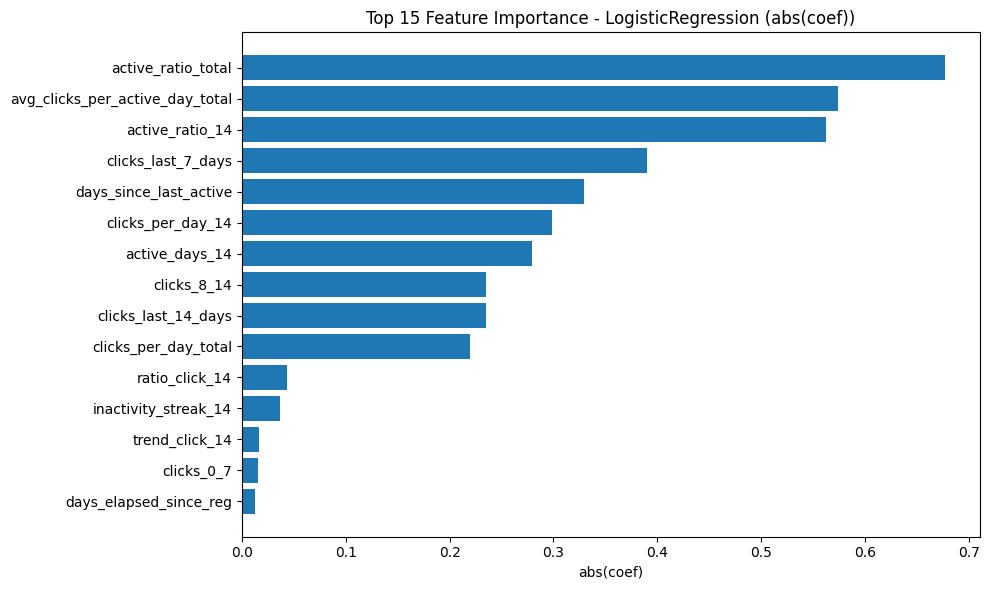

In [8]:
# === Cell 8: Feature importance (Logistic) ===
# Logistic importance: abs(coef) sau khi transform (power_transformer)
clf = loaded_pipe.named_steps["classifier"]
coefs = clf.coef_.ravel()
imp = pd.Series(np.abs(coefs), index=feature_cols).sort_values(ascending=False)

print("\n=== LogisticRegression Feature Importance (abs(coef)) TOP 15 ===")
print(imp.head(15).to_string())

topk = imp.head(15)[::-1]
plt.figure(figsize=(10, 6))
plt.barh(topk.index, topk.values)
plt.title("Top 15 Feature Importance - LogisticRegression (abs(coef))")
plt.xlabel("abs(coef)")
plt.tight_layout()
plt.show()